In [ ]:
import torch
import torchvision

In [ ]:
batch_size_train = 64
batch_size_test = 1000

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

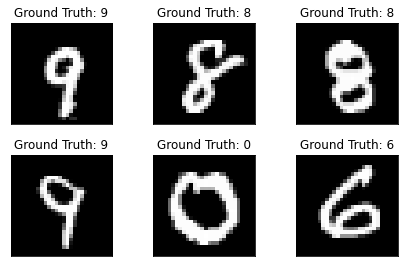

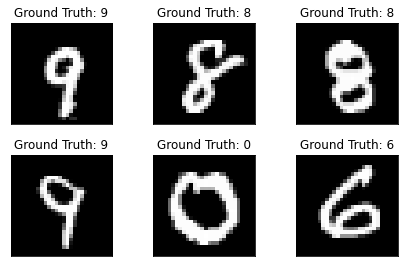

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325325
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.327831
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.277990
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275698
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.235048
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.258561
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.234983
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.201717
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.110235
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.005579
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.030873
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.844949
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.812574
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.721635
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.615330
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.393497
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.546457
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.497949
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.162648
Train Epoch: 1 [12160

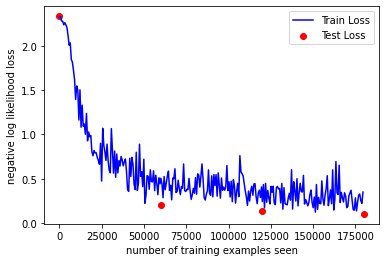

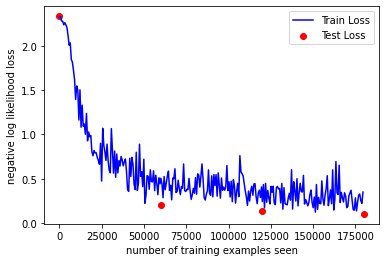

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


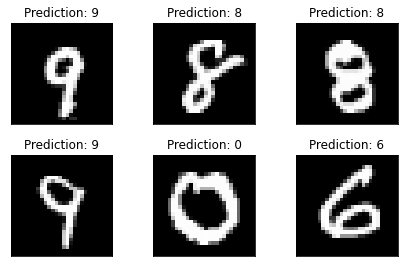

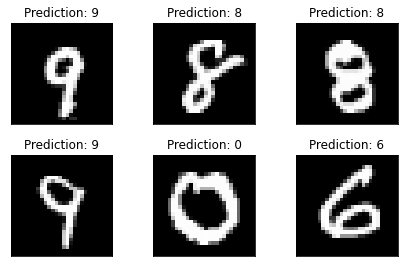

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
from google.colab import files
# files.download('MNIST_.pth')

In [ ]:
torch.save(network.state_dict(), 'MNIST_state_dict.pth')
files.download('MNIST_state_dict.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.upload()

Saving MNIST_state_dict.pth to MNIST_state_dict (4).pth


{'MNIST_state_dict.pth': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x12\x00archive/data.pklFB\x0e\x00ZZZZZZZZZZZZZZ\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\x0c\x00\x00\x00conv1.weightq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\t\x00\x00\x00109286640q\x06X\x03\x00\x00\x00cpuq\x07K\xfatq\x08QK\x00(K\nK\x01K\x05K\x05tq\t(K\x19K\x19K\x05K\x01tq\n\x89h\x00)Rq\x0btq\x0cRq\rX\n\x00\x00\x00conv1.biasq\x0eh\x03((h\x04h\x05X\t\x00\x00\x00109286560q\x0fh\x07K\ntq\x10QK\x00K\n\x85q\x11K\x01\x85q\x12\x89h\x00)Rq\x13tq\x14Rq\x15X\x0c\x00\x00\x00conv2.weightq\x16h\x03((h\x04h\x05X\t\x00\x00\x00147026304q\x17h\x07M\x88\x13tq\x18QK\x00(K\x14K\nK\x05K\x05tq\x19(K\xfaK\x19K\x05K\x01tq\x1a\x89h\x00)Rq\x1btq\x1cRq\x1dX\n\x00\x00\x00conv2.biasq\x1eh\x03((h\x04h\x05X\t\x00\x00\x00109283680q\x1fh\x07K\x14tq QK\x00K\x14\x85q!K\x01\x85q"\x89h\x00)Rq#tq$Rq%X\n\x00\x00\x00fc1.wei

In [ ]:
model = Net()

In [ ]:
model.load_state_dict(torch.load('MNIST_state_dict (4).pth'))

<All keys matched successfully>

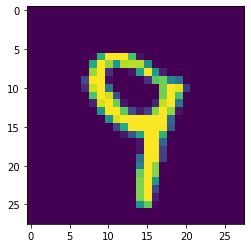

tensor([[1.2546e-09, 8.6999e-09, 5.2316e-08, 2.2925e-05, 4.4568e-03, 4.0817e-05,
         1.2272e-07, 4.5872e-04, 3.9173e-04, 9.9463e-01]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


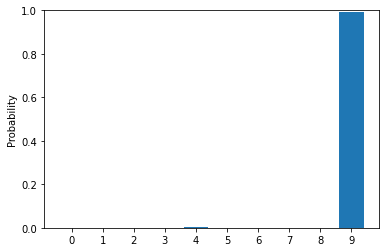

In [ ]:
img = example_data[3].unsqueeze(0)
plt.imshow(img[0][0])
plt.show()
with torch.no_grad():
  output = model.forward(img)

prob = torch.exp(output)
print(prob)
y = prob.detach()[0].numpy()
x = [x for x in range(10)]

plt.ylim([0, 1])
p1 = plt.bar(x, y)
plt.ylabel('Probability')
plt.xticks(x)

plt.show()